In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from prophet import Prophet

warnings.filterwarnings("ignore")

c:\Users\Kushal Yadav\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Amazon_df = pd.read_csv("../Amazon Sale Report.csv")
Cloud_Warehouse_df = pd.read_csv("../Cloud Warehouse Compersion Chart.csv") 
Expense_df = pd.read_csv("../Expense IIGF.csv")
international_sale_report_df = pd.read_csv("../International sale Report.csv")
May2022_df = pd.read_csv("../May-2022.csv")
PLMarch2021_df = pd.read_csv("../P  L March 2021.csv")
Sale_report_df = pd.read_csv("../Sale Report.csv")

In [3]:
Amazon_df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [4]:
Amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [5]:
amazon = Amazon_df
amazon.drop_duplicates(['Order ID','ASIN'],inplace = True,ignore_index=True)
amazon['Courier Status'].fillna('unknown',inplace=True)
amazon['promotion-ids'].fillna('no promotion',inplace=True)
amazon[amazon['Amount'].isnull()]['Status'].value_counts(normalize=True).apply(lambda x: format(x, '.2%'))
amazon['Amount'].fillna(0,inplace=True)
amazon['ship-city'].fillna('unknown', inplace = True)
amazon['ship-state'].fillna('unknown', inplace = True)
amazon['ship-postal-code'].fillna('unknown', inplace = True)

mapper = {'Order ID':'order_ID', 'Date':'date', 'Status':'ship_status','Fulfilment':'fullfilment',
          'ship-service-level':'service_level', 'Style':'style', 'SKU':'sku', 'Category':'product_category', 
          'Size':'size', 'ASIN':'asin', 'Courier Status':'courier_ship_status', 'Qty':'order_quantity', 
          'Amount':'order_amount_(Rs)', 'ship-city':'city', 'ship-state':'state', 'ship-postal-code':'zip', 
          'promotion-ids':'promotion','B2B':'customer_type'}
amazon.rename(columns=mapper, inplace =True)

amazon['customer_type'].replace(to_replace=[True,False],value=['business','customer'], inplace=True)
amazon['date'] = pd.to_datetime(amazon['date'])
amazon = amazon[(amazon['date'].dt.month != 3)]

month_map = { 4: 'april',5: 'may',6: 'june'}
amazon['month'] = amazon['date'].dt.month.map(month_map)

month_order = ['april', 'may', 'june']
amazon['month'] = pd.Categorical(amazon['month'], categories=month_order, ordered=True)

size_order = ['Free','XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL', '4XL', '5XL', '6XL']
amazon['size'] = pd.Categorical(amazon['size'], categories=size_order, ordered=True)

In [6]:
print(f'This dataset contains the months {amazon["month"].unique()} for 2022')
print(f'The earliest date is {amazon["date"].min()}')
print(f'The latest date is {amazon["date"].max()}')

This dataset contains the months ['april', 'may', 'june']
Categories (3, object): ['april' < 'may' < 'june'] for 2022
The earliest date is 2022-04-01 00:00:00
The latest date is 2022-06-29 00:00:00


In [7]:
Amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128968 entries, 0 to 128967
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   index                128968 non-null  int64         
 1   order_ID             128968 non-null  object        
 2   date                 128968 non-null  datetime64[ns]
 3   ship_status          128968 non-null  object        
 4   fullfilment          128968 non-null  object        
 5   Sales Channel        128968 non-null  object        
 6   service_level        128968 non-null  object        
 7   style                128968 non-null  object        
 8   sku                  128968 non-null  object        
 9   product_category     128968 non-null  object        
 10  size                 128968 non-null  object        
 11  asin                 128968 non-null  object        
 12  courier_ship_status  128968 non-null  object        
 13  order_quantity

In [8]:
revenue_by_month = amazon.groupby('month')['order_amount_(Rs)'].sum()
percent_decrease_apr_to_may = (revenue_by_month['april'] - revenue_by_month['may']) / revenue_by_month['april'] * 100
percent_decrease_may_to_jun = (revenue_by_month['may'] - revenue_by_month['june']) / revenue_by_month['may'] * 100
total_decrease = (revenue_by_month['april'] - revenue_by_month['june']) / revenue_by_month['april'] * 100
print(f"Total revenue for April 2022: Rs. {revenue_by_month['april']:,.2f}")
print(f"Total revenue for May 2022: Rs. {revenue_by_month['may']:,.2f}, which is a -{percent_decrease_apr_to_may:.2f}% decrease from April.")
print(f"Total revenue for June 2022: Rs. {revenue_by_month['june']:,.2f}, which is a -{percent_decrease_may_to_jun:.2f}% decrease from May.")
print(f"Total revenue for Q2 2022 decreased by -{total_decrease:.2f}%")
print("\n")

revenue_by_category = amazon.groupby('product_category')['order_amount_(Rs)'].sum().sort_values(ascending=False)
print("Total revenue by product category:") 
print(revenue_by_category.apply(lambda x: "Rs. {:,.2f}".format(x)))
print("\n")

revenue_by_category = amazon.groupby('product_category')['order_amount_(Rs)'].sum()
percent_revenue_by_category = ((revenue_by_category / revenue_by_category.sum()) * 100).sort_values(ascending=False)
percent_revenue_by_category = percent_revenue_by_category.apply(lambda x: "{:.2f}%".format(x))
print("Percentage of revenue by product category:")
print(percent_revenue_by_category)
print("\n")

avg_price_by_category = amazon.groupby('product_category')['order_amount_(Rs)'].mean()
avg_price_by_category = avg_price_by_category.sort_values(ascending=False)
print("Top 5 product categories by average price:")
print(avg_price_by_category.head(5))
print("\n")

cancelled_orders = amazon[amazon['ship_status'].isin(['Cancelled', 'Shipped - Lost in Transit'])]
returned_orders = amazon[amazon['ship_status'].isin(['Shipped - Returned to Seller', 'Shipped - Returning to Seller', 'Shipped - Rejected by Buyer', 'Shipped - Damaged'])]
total_cancelled = len(cancelled_orders)
total_returned = len(returned_orders)
total_cancelled_returned = total_cancelled + total_returned
percent_cancelled = total_cancelled / len(amazon) * 100
percent_returned = total_returned / len(amazon) * 100
percent_cancelled_returned = total_cancelled_returned / amazon['order_quantity'].sum() * 100
print(f"Total cancelled orders: {total_cancelled}, which is {percent_cancelled:.2f}% of all orders.")
print(f"Total returned orders: {total_returned}, which is {percent_returned:.2f}% of all orders.")
print(f"This represents {percent_cancelled_returned:.2f}% of all orders.")
print("\n")


monthly_order_data = amazon.groupby(pd.Grouper(key='date', freq='M')).agg({'order_amount_(Rs)': 'mean', 'order_quantity': 'mean'})
monthly_order_data = monthly_order_data.rename(columns={'order_amount_(Rs)': 'average_order_amount', 'order_quantity': 'average_order_quantity'})
print(monthly_order_data)
print("\n")

popular_category_by_state = amazon.groupby(['state', 'product_category'])['order_quantity'].sum().reset_index()
popular_category_by_state = popular_category_by_state.sort_values(['state', 'order_quantity'], ascending=[True, False])
popular_category_by_state = popular_category_by_state.drop_duplicates(subset=['state'])
print("Most popular product category in each state:")
print(popular_category_by_state)
print("\n")

avg_order_amount_by_customer_type = amazon.groupby('customer_type')['order_amount_(Rs)'].mean()
print("Average order amount by customer type:")
print(avg_order_amount_by_customer_type.apply(lambda x: "Rs. {:,.2f}".format(x)))


Total revenue for April 2022: Rs. 28,838,708.32
Total revenue for May 2022: Rs. 26,224,517.75, which is a -9.06% decrease from April.
Total revenue for June 2022: Rs. 23,424,646.38, which is a -10.68% decrease from May.
Total revenue for Q2 2022 decreased by -18.77%


Total revenue by product category:
product_category
Set              Rs. 39,148,138.03
kurta            Rs. 21,264,270.13
Western Dress    Rs. 11,208,419.41
Top               Rs. 5,343,281.30
Ethnic Dress        Rs. 790,118.66
Blouse              Rs. 458,128.18
Bottom              Rs. 150,667.98
Saree               Rs. 123,933.76
Dupatta                 Rs. 915.00
Name: order_amount_(Rs), dtype: object


Percentage of revenue by product category:
product_category
Set              49.88%
kurta            27.09%
Western Dress    14.28%
Top               6.81%
Ethnic Dress      1.01%
Blouse            0.58%
Bottom            0.19%
Saree             0.16%
Dupatta           0.00%
Name: order_amount_(Rs), dtype: object


Top 5 

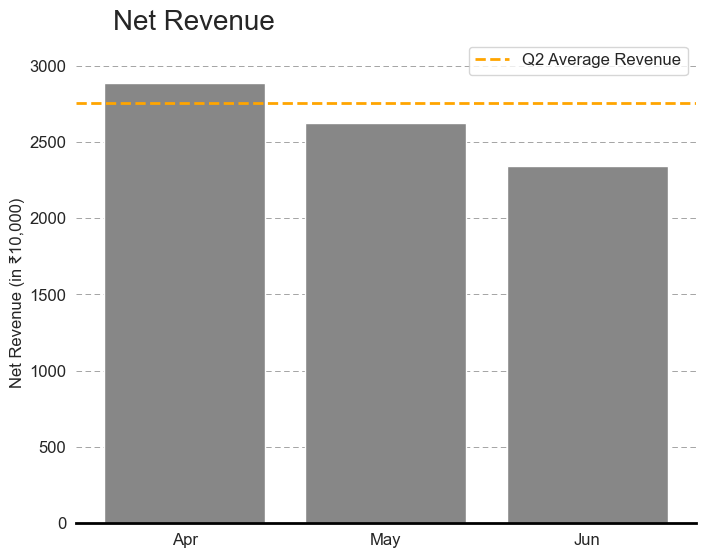

In [9]:
sns.set_style('whitegrid')
monthly_sales = amazon.groupby(pd.Grouper(key='date', freq='M')).agg({'order_amount_(Rs)': 'sum'})
monthly_sales['order_amount_(Rs)'] = monthly_sales['order_amount_(Rs)'] / 10000  

latest_month_revenue = monthly_sales.tail(1).iloc[0][0]
avg_quarterly_revenue = monthly_sales.tail(3).head(2).mean()[0]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(monthly_sales.index.strftime('%b'), monthly_sales['order_amount_(Rs)'], color='#878787')


for i, bar in enumerate(bars):
    if i == len(bars) - 1 or i < len(bars) - 2:
        continue
    month_sales = monthly_sales.iloc[i]['order_amount_(Rs)']
    pct_below_avg = round((1 - (month_sales / avg_quarterly_revenue)) * 100, 1)
    """
    ax.annotate(f'{pct_below_avg}% below avg.', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height() - 7), 
                xytext=(0, 5), textcoords='offset points', fontweight='bold', 
                ha='center', va='bottom', fontsize=14)
    """

latest_bar = bars[-1]
latest_month_sales = latest_bar.get_height()
pct_below_avg = round((1 - (latest_month_sales / avg_quarterly_revenue)) * 100, 1)
"""
ax.annotate(f'{pct_below_avg}% below avg.', 
            xy=(latest_bar.get_x() + latest_bar.get_width()/2, latest_bar.get_height() - 7), 
            xytext=(0, 5), textcoords='offset points', fontweight='bold',
            ha='center', va='bottom', fontsize=14)
"""

plt.axhline(avg_quarterly_revenue, linestyle='--', color='orange', linewidth=2, label='Q2 Average Revenue')
ax.set_title('Net Revenue', fontsize=20, x=.19, y=1.05)
ax.set_xlabel(None)
ax.set_ylabel('Net Revenue (in ₹10,000)', fontsize=12, labelpad=3)

ax.yaxis.grid(linestyle='--', color='gray', linewidth=0.5, dashes=(8, 5))
ax.xaxis.grid(False)

plt.legend(bbox_to_anchor=(1, 1.05), fontsize=12, fancybox=True)

ax.tick_params(axis='both', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

plt.show()

##plt.savefig('net revenue.png', dpi=300)

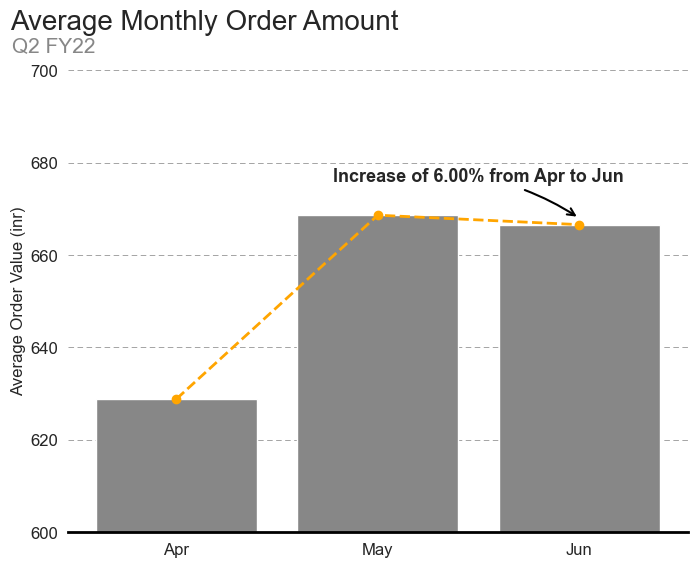

In [10]:
monthly_aov = amazon.groupby(pd.Grouper(key='date', freq='M')).agg({'order_amount_(Rs)': 'sum', 'order_ID': 'nunique'})
monthly_aov['average_order_value'] = monthly_aov['order_amount_(Rs)'] / monthly_aov['order_ID']

monthly_aov['pct_change'] = monthly_aov['average_order_value'].pct_change() * 100

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=monthly_aov.index.strftime('%b'), y=monthly_aov['average_order_value'], ax=ax, color='#878787')

ax.plot(monthly_aov.index.strftime('%b'), monthly_aov['average_order_value'], linestyle='--', linewidth=2, color='orange', marker='o')

apr_val = monthly_aov['average_order_value'][0]
jun_val = monthly_aov['average_order_value'][2]
pct_change = ((jun_val - apr_val) / apr_val) * 100
ax.annotate(f'Increase of {pct_change:.2f}% from Apr to Jun',fontweight='bold', xy=(2,668), xytext=(1.5,675), fontsize=13, ha='center', va='bottom', arrowprops=dict(arrowstyle='->', color='black', lw=1.5, connectionstyle="arc3,rad=-0.1"))

ax.set_title('Average Monthly Order Amount', fontsize=20, x=.22, y=1.07)
ax.text(-0.09, 1.04, 'Q2 FY22', fontsize=15, color='#878787', transform=ax.transAxes)
ax.set_xlabel(None)
ax.set_ylabel('Average Order Value (inr)', fontsize=12, labelpad=3)
ax.set_ylim(600,700)
ax.yaxis.grid(linestyle='--', color='gray', linewidth=0.5, dashes=(8, 5))

ax.tick_params(axis='both', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

plt.show()
#plt.savefig('average monthly order amount.png', dpi=300)

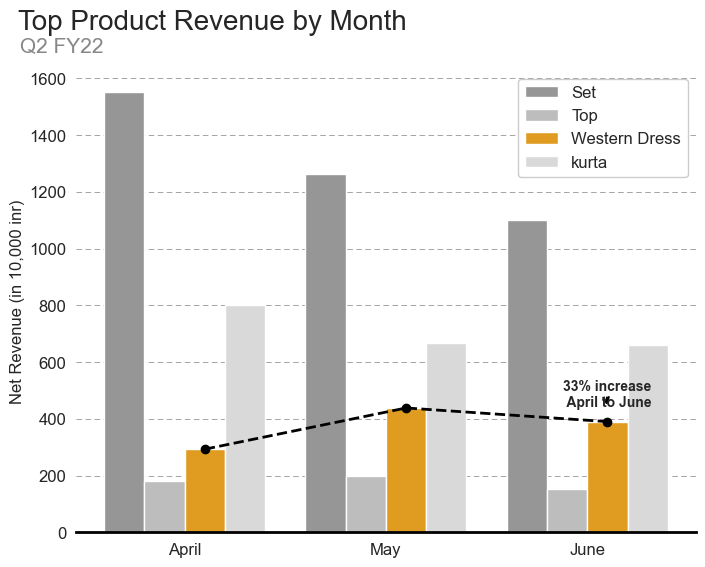

In [11]:
import warnings
warnings.filterwarnings('ignore')

#fig, ax = plt.subplots(figsize=(8,6))

month_order = ['April', 'May', 'June']

sales_data = amazon[amazon['product_category'].isin(['Western Dress', 'Top', 'kurta', 'Set'])]

sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data['month'] = sales_data['date'].dt.month_name()

sales_by_month = sales_data.groupby(['month', 'product_category'])['order_amount_(Rs)'].sum().reset_index()

sales_by_month['month'] = pd.Categorical(sales_by_month['month'], categories=month_order, ordered=True)

sales_by_month['order_amount_(Rs)'] = sales_by_month['order_amount_(Rs)'] / 10000

fig, ax = plt.subplots(figsize=(8,6))

ax = sns.barplot(x='month', y='order_amount_(Rs)', hue='product_category', data=sales_by_month,
                 palette=['#969696', '#bdbdbd', 'orange', '#d9d9d9'])

sales_wd = sales_by_month[sales_by_month['product_category'] == 'Western Dress'].reset_index(drop=True)
sales_wd['month'] = pd.Categorical(sales_wd['month'], categories=month_order, ordered=True)
sales_wd.sort_values(by='month', inplace=True)

ax.plot([0.1, 1.1, 2.1], sales_wd['order_amount_(Rs)'], color='black', linestyle='--', linewidth=2, marker='o')

pct_increase = (sales_wd.loc[1, 'order_amount_(Rs)'] - sales_wd.loc[0, 'order_amount_(Rs)']) / sales_wd.loc[0, 'order_amount_(Rs)'] * 100
ax.annotate(f'{pct_increase:.0f}% increase\n April to June', fontweight='bold', 
            xy=(2.1, sales_wd.loc[2, 'order_amount_(Rs)']), 
            xytext=(1.88, sales_wd.loc[2, 'order_amount_(Rs)'] + 4),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5, connectionstyle="arc3,rad=0.1"))

ax.set_title('Top Product Revenue by Month', fontsize=20, x=.22, y=1.07)
ax.text(-0.09, 1.04, 'Q2 FY22', fontsize=15, color='#878787', transform=ax.transAxes)

plt.legend(bbox_to_anchor=(1,1), fontsize=12, framealpha=1)

ax.set_xlabel(None)
ax.set_ylabel('Net Revenue (in 10,000 inr)', fontsize=12, labelpad=3)

ax.yaxis.grid(linestyle='--', color='gray', linewidth=0.5, dashes=(8, 5))
ax.tick_params(axis='both', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

plt.show()

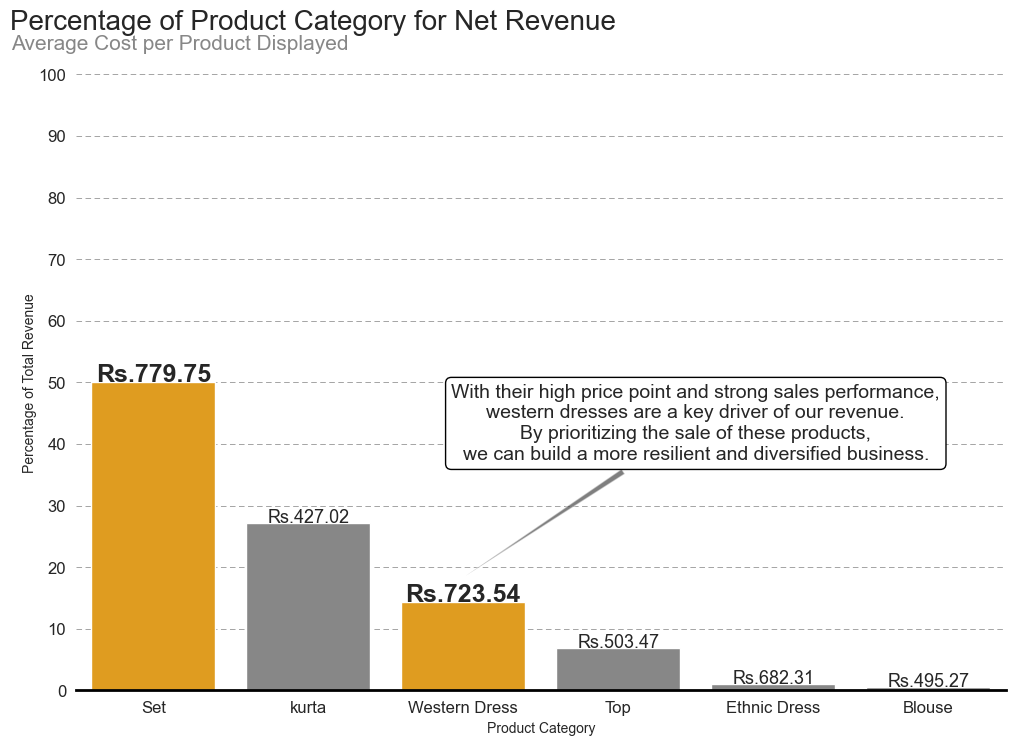

In [12]:
sales_by_category = amazon.groupby('product_category')['order_amount_(Rs)'].sum()

included_categories = ['Set', 'kurta', 'Western Dress', 'Top', 'Ethnic Dress', 'Blouse']
sales_by_category = sales_by_category.loc[included_categories]

total_revenue = sales_by_category.sum()

sales_by_category_pct = (sales_by_category / total_revenue) * 100

sales_by_category_pct = sales_by_category_pct.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
palette_colors = ['orange' if cat in ['Set', 'Western Dress'] else '#878787' for cat in sales_by_category_pct.index]
sns.barplot(x=sales_by_category_pct.index, y=sales_by_category_pct.values, ax=ax, palette=palette_colors)
num_y_ticks = 10
y_tick_values = list(range(0,101,10))

ax.set_yticks(y_tick_values)

ax.set_ylabel('Percentage of Total Revenue', labelpad=1)
ax.set_ylim(0, 100)
ax.set_xlabel('Product Category', labelpad=5)
ax.set_title('Percentage of Product Category for Net Revenue', fontsize=20, x=0.255, y=1.05, pad=10)
ax.text(-.07, 1.04, 'Average Cost per Product Displayed', fontsize=15, color='#878787', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=12)
ax.yaxis.grid(linestyle='--', color='gray', linewidth=0.5, dashes=(8, 5))
ax.xaxis.grid(False)

for i, category in enumerate(sales_by_category_pct.index):
    avg_cost = amazon[amazon['product_category'] == category]['order_amount_(Rs)'].mean()
    if category in ['Set', 'Western Dress']:
        ax.text(i, sales_by_category_pct.values[i] +.1, f'Rs.{avg_cost:.2f}', ha='center', fontsize=18, fontweight='bold')
    else:
        ax.text(i, sales_by_category_pct.values[i] +.1, f'Rs.{avg_cost:.2f}', ha='center', fontsize=13)

western_sales = sales_by_category_pct['Western Dress']
western_index = sales_by_category_pct.index.get_loc('Western Dress')

bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=1)
arrow_props = dict(facecolor='black', arrowstyle='wedge', alpha=0.5)

x_pos = western_index
y_pos = western_sales + 2
x_text = x_pos + 0.5
y_text = y_pos - 8

western_pct = (western_sales / total_revenue) * 100
ax.annotate('With their high price point and strong sales performance,\nwestern dresses are a key driver of our revenue.\nBy prioritizing the sale of these products,\nwe can build a more resilient and diversified business.', xy=(x_pos, y_pos+2), xytext=(x_text+1, y_text+35), fontsize=14,
arrowprops=arrow_props, bbox=bbox_props, ha='center', va='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
plt.show()
#fig.savefig('Percent_Prod_Revenuw.png', dpi=300)

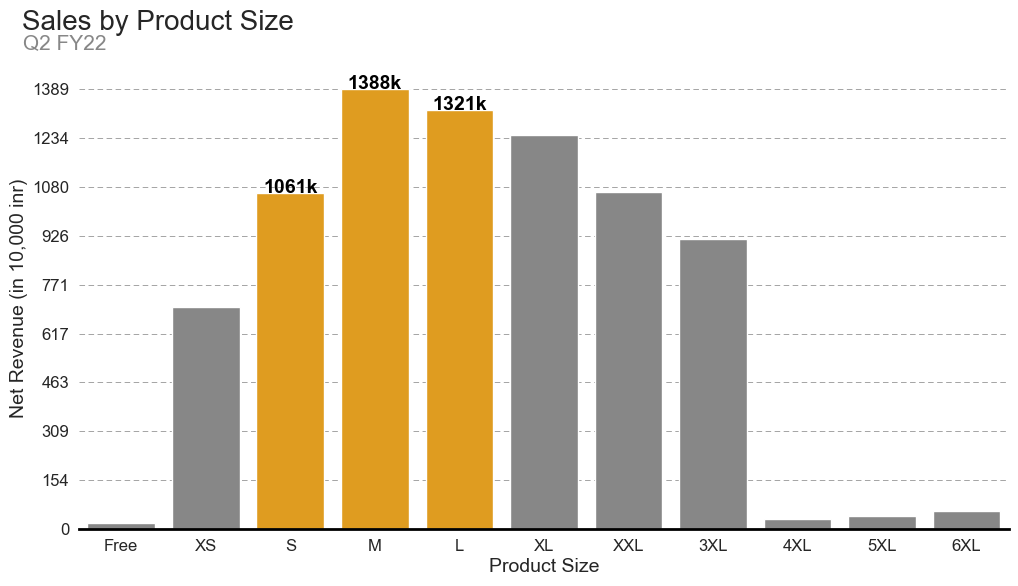

In [13]:
sales_by_size = amazon.groupby('size')['order_amount_(Rs)'].sum()
sales_by_size = sales_by_size / 10000

fig, ax = plt.subplots(figsize=(12,6))

palette_colors = ['orange' if size in ['S', 'M', 'L'] else '#878787' for size in sales_by_size.index]
sns.barplot(x=sales_by_size.index, y=sales_by_size.values, ax=ax, palette=palette_colors)

ax.set_xlabel('Product Size', labelpad=3, fontsize=14)
ax.set_ylabel('Net Revenue (in 10,000 inr)', labelpad=3, fontsize=14)
ax.set_title('Sales by Product Size', fontsize=20, x=0.085, y=1.05, pad=10)
ax.text(-0.06, 1.04, 'Q2 FY22', fontsize=15, color='#878787', transform=ax.transAxes)

ax.tick_params(axis='both', labelsize=12)
ax.yaxis.grid(linestyle='--', color='gray', linewidth=0.5, dashes=(8, 5))
ax.xaxis.grid(False)

num_y_ticks = 10
y_tick_values = np.linspace(0, sales_by_size.values.max(), num_y_ticks)
ax.set_yticks(y_tick_values)

for i, size in enumerate(sales_by_size.index):
    if size in ['S', 'M', 'L']:
        ax.text(i, sales_by_size.values[i] + 0.5, f'{int(sales_by_size.values[i])}k',
                ha='center', fontsize=14, fontweight='bold', color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

plt.show()
#fig.savefig('Sales_Prod_Size.png', dpi=300)


In [14]:
international_sale_report_df['RATE'] = pd.to_numeric(international_sale_report_df['RATE'], errors='coerce')
international_sale_report_df['PCS'] = pd.to_numeric(international_sale_report_df['PCS'], errors='coerce')
international_sale_report_df['GROSS AMT'] = pd.to_numeric(international_sale_report_df['GROSS AMT'], errors='coerce')

cleaned_sales_df = international_sale_report_df.dropna(subset=['RATE', 'PCS', 'GROSS AMT'])

sales_summary = cleaned_sales_df.groupby('CUSTOMER').agg(total_pcs_sold=('PCS', 'sum'), total_revenue=('GROSS AMT', 'sum')).reset_index()

top_countries = sales_summary.sort_values(by='total_revenue', ascending=False)

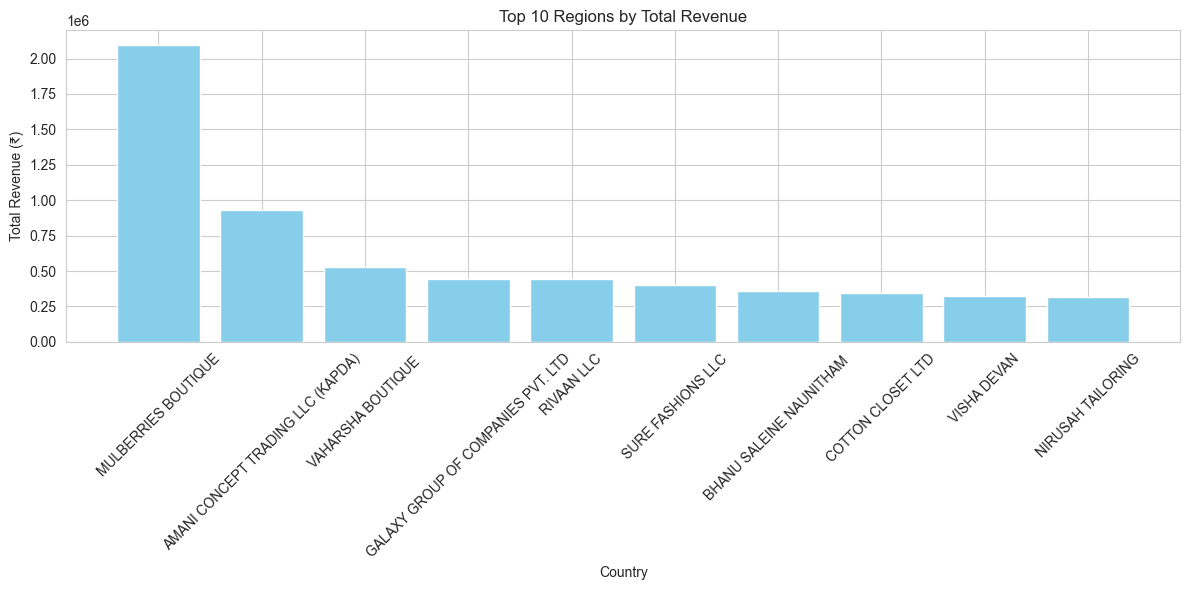

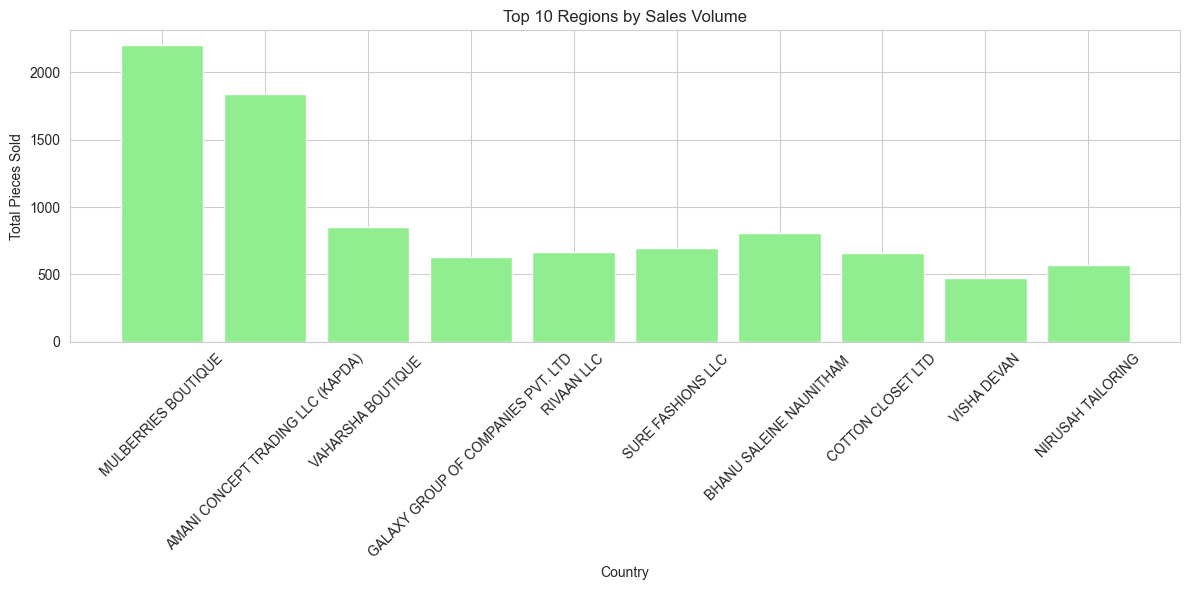

In [15]:
plt.figure(figsize=(12, 6))
plt.bar(top_countries['CUSTOMER'][:10], top_countries['total_revenue'][:10], color='skyblue')
plt.title('Top 10 Regions by Total Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue (₹)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#plt.savefig('top ten regions by revenue.png', dpi=300)

plt.figure(figsize=(12, 6))
plt.bar(top_countries['CUSTOMER'][:10], top_countries['total_pcs_sold'][:10], color='lightgreen')
plt.title('Top 10 Regions by Sales Volume')
plt.xlabel('Country')
plt.ylabel('Total Pieces Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#plt.savefig('Top ten regions by volume.png', dpi=300)

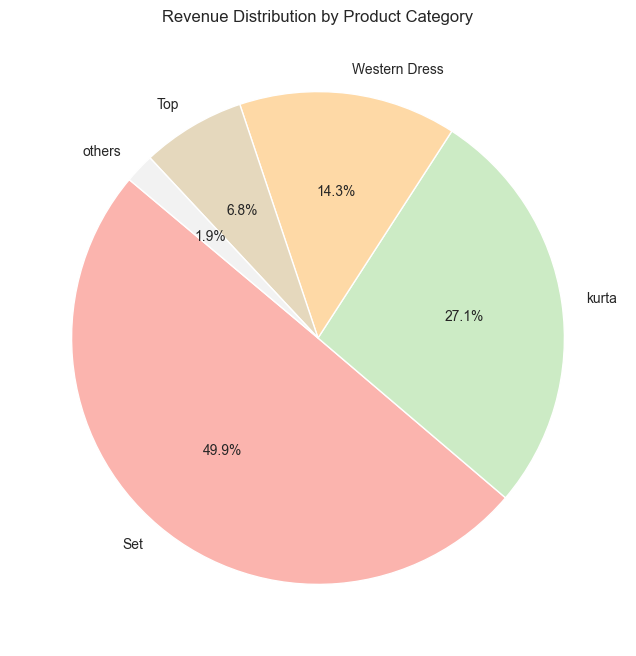

product_category
Set              39148138.03
kurta            21264270.13
Western Dress    11208419.41
Top               5343281.30
others            1523763.58
Name: order_amount_(Rs), dtype: float64


In [16]:
top_4 = revenue_by_category.sort_values(ascending=False)[:4]
other = revenue_by_category.sort_values(ascending=False)[4:].sum()

top_4['others'] = other

plt.figure(figsize=(8, 8))
top_4.plot.pie(autopct='%1.1f%%', startangle=140, cmap='Pastel1')
plt.title('Revenue Distribution by Product Category')
plt.ylabel('')
plt.show()

print(top_4)
#plt.savefig('revenue distribution by product category.png', dpi=300)

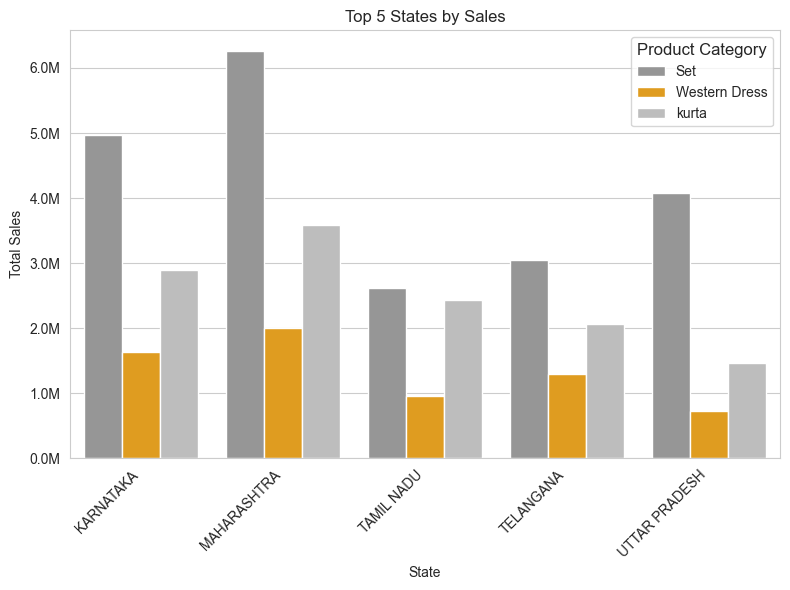

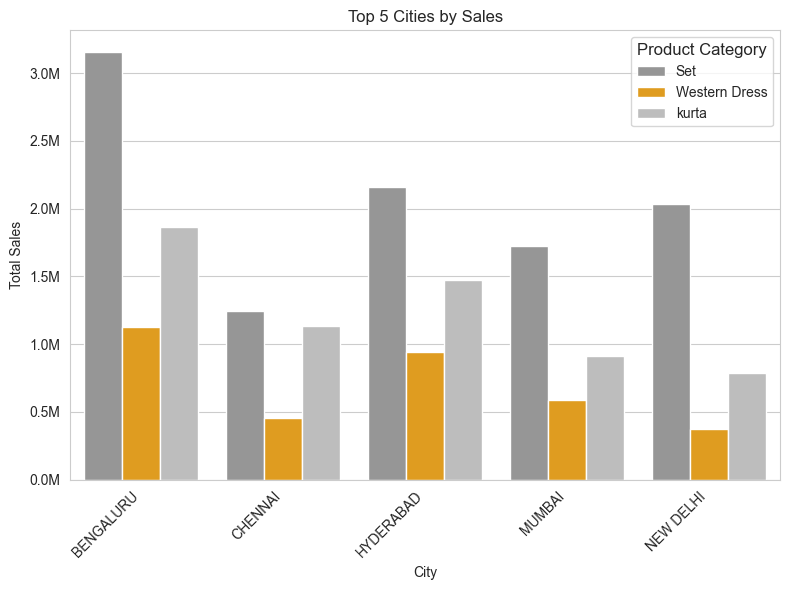

In [17]:
colors = {'Top': '#d9d9d9', 'Set': '#969696', 'kurta': '#bdbdbd', 'Western Dress': 'orange'}

sales_by_state = amazon.groupby('state')['order_amount_(Rs)'].sum()
top_5_states = sales_by_state.nlargest(5).index.tolist()
top_sales_states = amazon[amazon['state'].isin(top_5_states)]
sales_by_state_product = top_sales_states.groupby(['state', 'product_category'])['order_amount_(Rs)'].sum().reset_index()
top_products_states = sales_by_state_product.groupby('state').apply(lambda x: x.nlargest(3, 'order_amount_(Rs)'))['product_category'].tolist()

sales_by_city = amazon.groupby('city')['order_amount_(Rs)'].sum()
top_5_cities = sales_by_city.nlargest(5).index.tolist()
top_sales_cities = amazon[amazon['city'].isin(top_5_cities)]
sales_by_city_product = top_sales_cities.groupby(['city', 'product_category'])['order_amount_(Rs)'].sum().reset_index()
top_products_cities = sales_by_city_product.groupby('city').apply(lambda x: x.nlargest(3, 'order_amount_(Rs)'))['product_category'].tolist()


fig1, ax1 = plt.subplots(figsize=(8, 6))
state_sales_filtered = sales_by_state_product[sales_by_state_product['state'].isin(top_5_states)]
state_sales_filtered = state_sales_filtered[state_sales_filtered['product_category'].isin(top_products_states)]

sns.barplot(x='state', y='order_amount_(Rs)', hue='product_category', data=state_sales_filtered, palette=colors, ax=ax1)
ax1.set_title('Top 5 States by Sales')
ax1.set_xlabel('State')
ax1.set_ylabel('Total Sales')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Product Category', fontsize=10, title_fontsize=12, loc='upper right')
plt.tight_layout()
#plt.savefig('Top_Products_States.png', dpi=300)
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 6))
city_sales_filtered = sales_by_city_product[sales_by_city_product['city'].isin(top_5_cities)]
city_sales_filtered = city_sales_filtered[city_sales_filtered['product_category'].isin(top_products_cities)]

sns.barplot(x='city', y='order_amount_(Rs)', hue='product_category', data=city_sales_filtered, palette=colors, ax=ax2)
ax2.set_title('Top 5 Cities by Sales')
ax2.set_xlabel('City')
ax2.set_ylabel('Total Sales')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(title='Product Category', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()
#plt.savefig('Top_Products_Cities.png', dpi=300)
plt.show()


Testing for stationarity before differencing:
ADF Statistic: -2.0759418770813927
p-value: 0.25429786777807367
The data is NOT stationary.

Testing for stationarity after differencing:
ADF Statistic: -6.791900282475869
p-value: 2.3530971558676772e-09
The data is stationary.


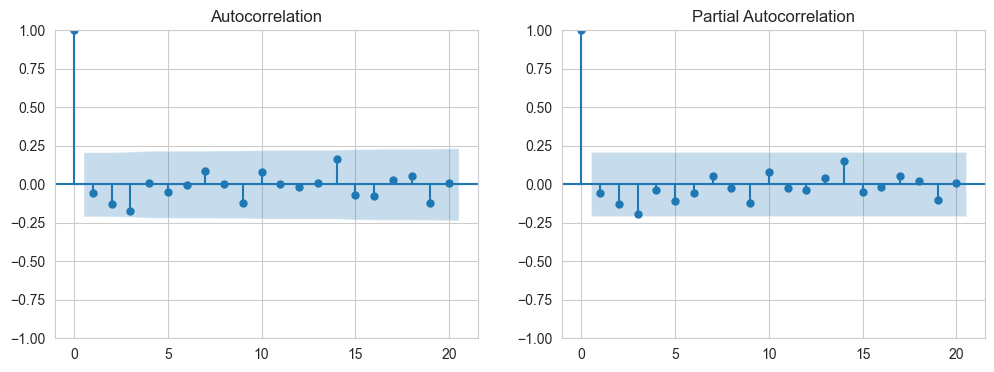

In [18]:
daywise_sales = amazon.groupby('date').agg(total_qty=('order_quantity', 'sum'), total_amount=('order_amount_(Rs)', 'sum')).reset_index()
daywise_sales.set_index('date', inplace=True)

def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary.")

print("\nTesting for stationarity before differencing:")
adf_test(daywise_sales['total_qty'])

daywise_sales['total_qty_diff'] = daywise_sales['total_qty'].diff().dropna()

print("\nTesting for stationarity after differencing:")
adf_test(daywise_sales['total_qty_diff'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(daywise_sales['total_qty_diff'].dropna(), ax=axes[0])
plot_pacf(daywise_sales['total_qty_diff'].dropna(), ax=axes[1])
plt.show()

15:11:31 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing


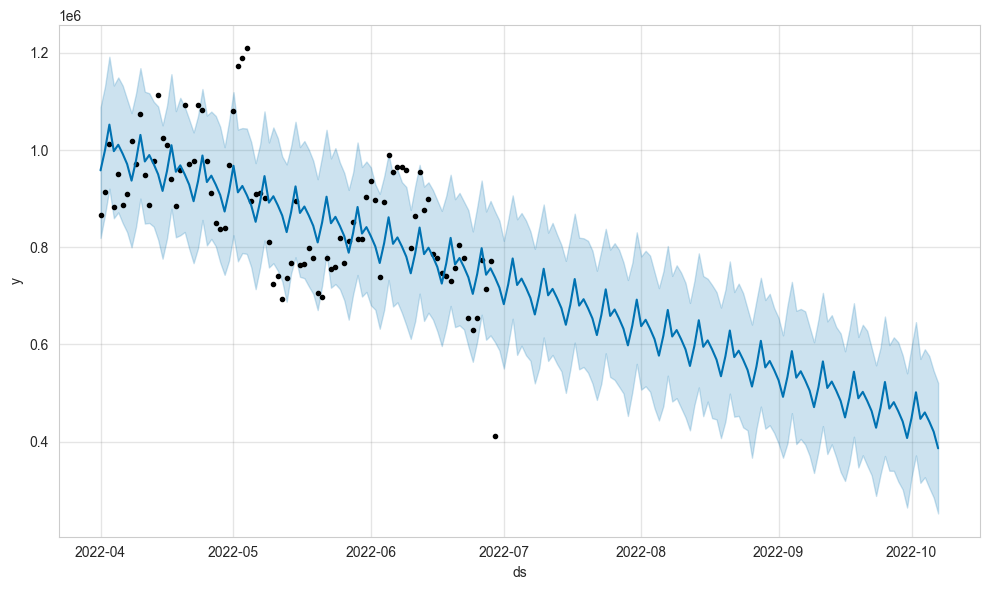

In [19]:
df_prophet = daywise_sales.reset_index().rename(columns={'date': 'ds', 'total_amount': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=100)
forecast_prophet = model_prophet.predict(future)
model_prophet.plot(forecast_prophet)
plt.show()
#plt.savefig('trend forcast.png', dpi=300)

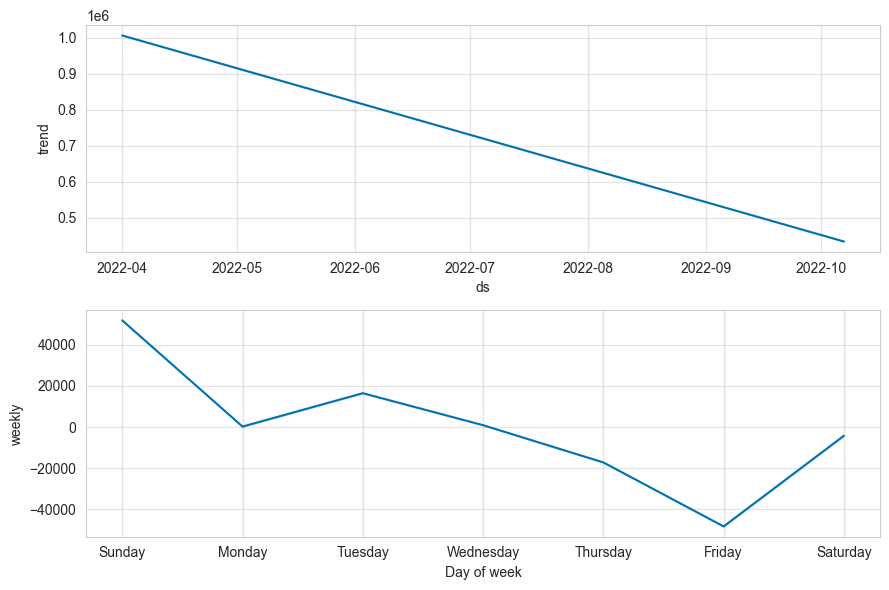

In [20]:
model_prophet.plot_components(forecast_prophet)
plt.show()
#plt.savefig('forecast components.png', dpi=300)

In [21]:
total_orders = amazon.groupby('product_category')['order_quantity'].sum().reset_index()
cancelled_orders = amazon[amazon['ship_status'] == 'Cancelled'].groupby('product_category')['order_quantity'].sum().reset_index()
returned_orders = amazon[amazon['ship_status'].str.contains('Returned|Rejected', na=False)] \
                  .groupby('product_category')['order_quantity'].sum().reset_index()

merged_df = total_orders.merge(cancelled_orders, on='product_category', how='left', suffixes=('_Total', '_Cancelled')) \
                        .merge(returned_orders, on='product_category', how='left')

merged_df = merged_df.fillna(0)
merged_df.rename(columns={
    'order_quantity_Total': 'Total_Orders',
    'order_quantity_Cancelled': 'Cancelled_Orders',
    'order_quantity': 'Returned_Orders'
}, inplace=True)

merged_df['Cancellation_Rate'] = merged_df['Cancelled_Orders'] / merged_df['Total_Orders']
merged_df['Return_Rate'] = merged_df['Returned_Orders'] / merged_df['Total_Orders']

print(merged_df)


  product_category  Total_Orders  Cancelled_Orders  Returned_Orders  \
0           Blouse           862              32.0             12.0   
1           Bottom           398              14.0              5.0   
2          Dupatta             3               0.0              0.0   
3     Ethnic Dress          1052              36.0             16.0   
4            Saree           152               5.0              1.0   
5              Set         45219            2253.0            771.0   
6              Top          9894             535.0            130.0   
7    Western Dress         13937             525.0            314.0   
8            kurta         44972            2253.0            731.0   

   Cancellation_Rate  Return_Rate  
0           0.037123     0.013921  
1           0.035176     0.012563  
2           0.000000     0.000000  
3           0.034221     0.015209  
4           0.032895     0.006579  
5           0.049824     0.017050  
6           0.054073     0.013139  
7

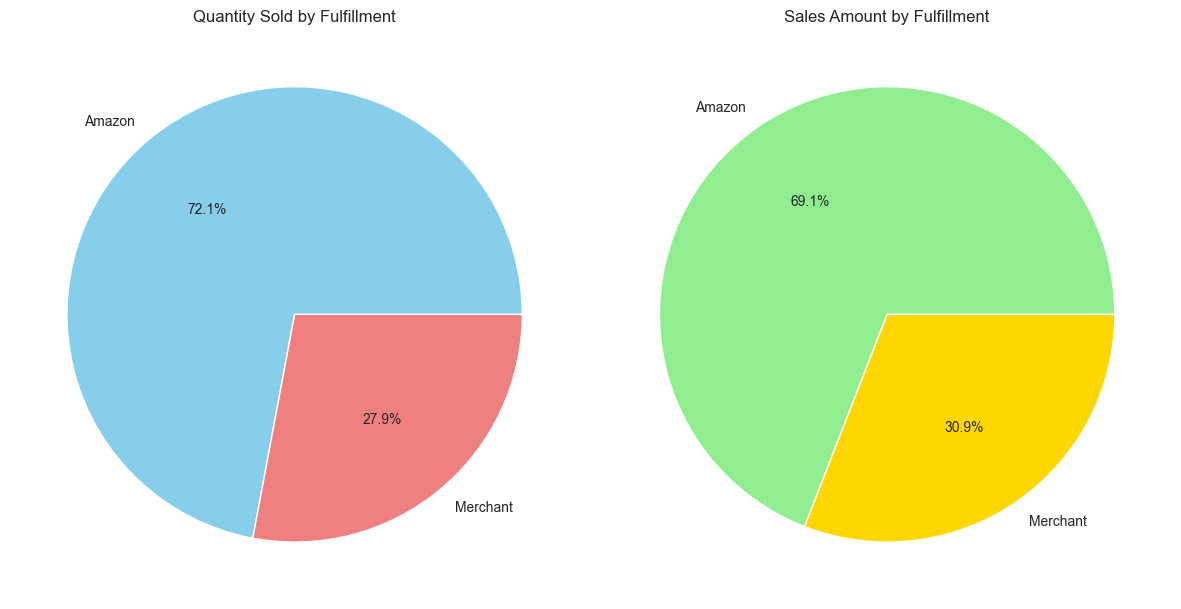

In [22]:
qty_data = amazon.groupby('fullfilment')['order_quantity'].sum()
amount_data = amazon.groupby('fullfilment')['order_amount_(Rs)'].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(qty_data, labels=qty_data.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[0].set_title('Quantity Sold by Fulfillment')

axes[1].pie(amount_data, labels=amount_data.index, autopct='%1.1f%%', colors=['lightgreen', 'gold'])
axes[1].set_title('Sales Amount by Fulfillment')

plt.tight_layout()
plt.show()
#plt.savefig('fulfillment distribution.png', dpi=300)

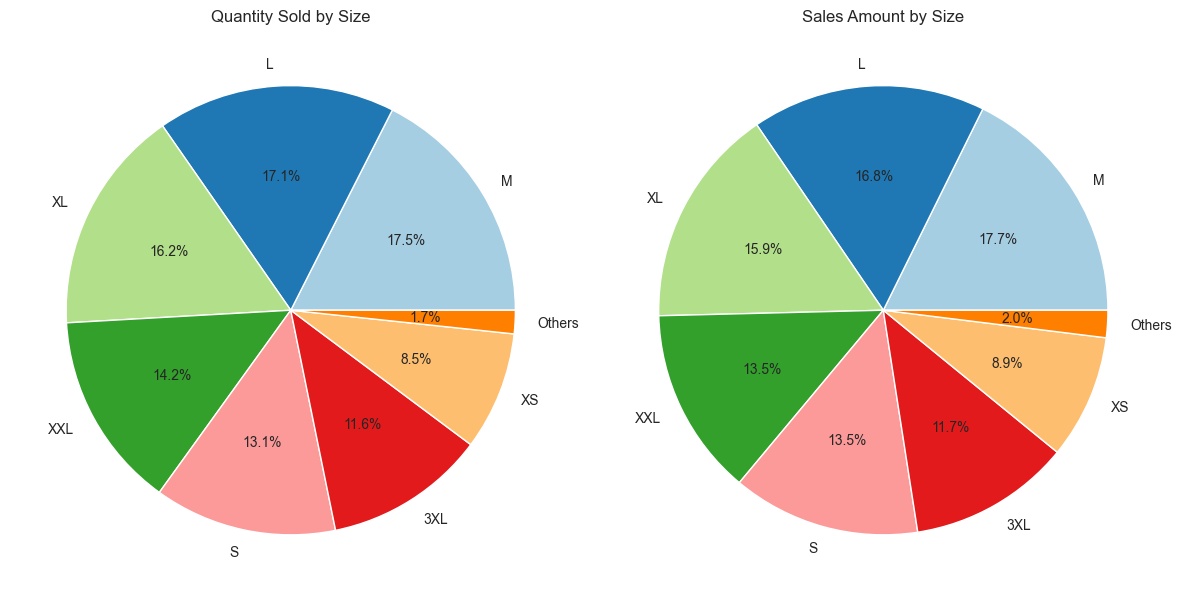

In [23]:
qty_data = Amazon_df.groupby('size')['order_quantity'].sum().sort_values(ascending=False)
amount_data = Amazon_df.groupby('size')['order_amount_(Rs)'].sum().sort_values(ascending=False)

top_7_sizes = qty_data[:7]
other_qty = qty_data[7:].sum()
other_amount = amount_data[7:].sum()

if other_qty > 0:
    top_7_sizes['Others'] = other_qty
if other_amount > 0:
    amount_data = amount_data[:7]
    amount_data['Others'] = other_amount


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(top_7_sizes, labels=top_7_sizes.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set_title('Quantity Sold by Size')

axes[1].pie(amount_data, labels=amount_data.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set_title('Sales Amount by Size')

plt.tight_layout()
plt.show()
#plt.savefig('size distribution.png', dpi=300)

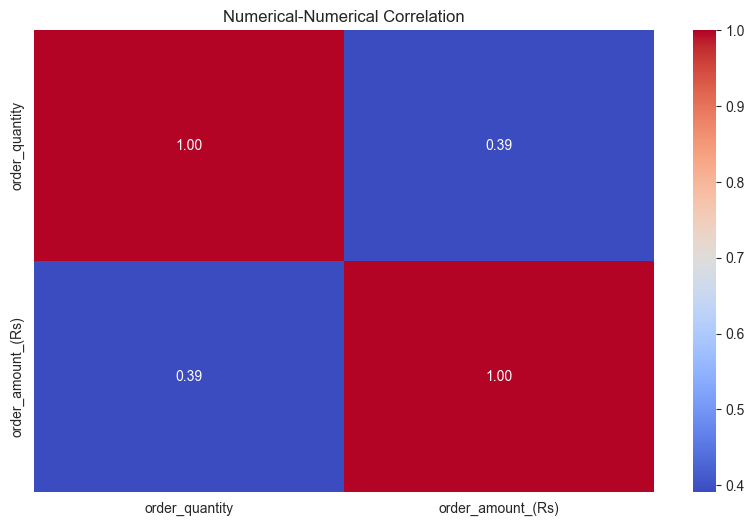

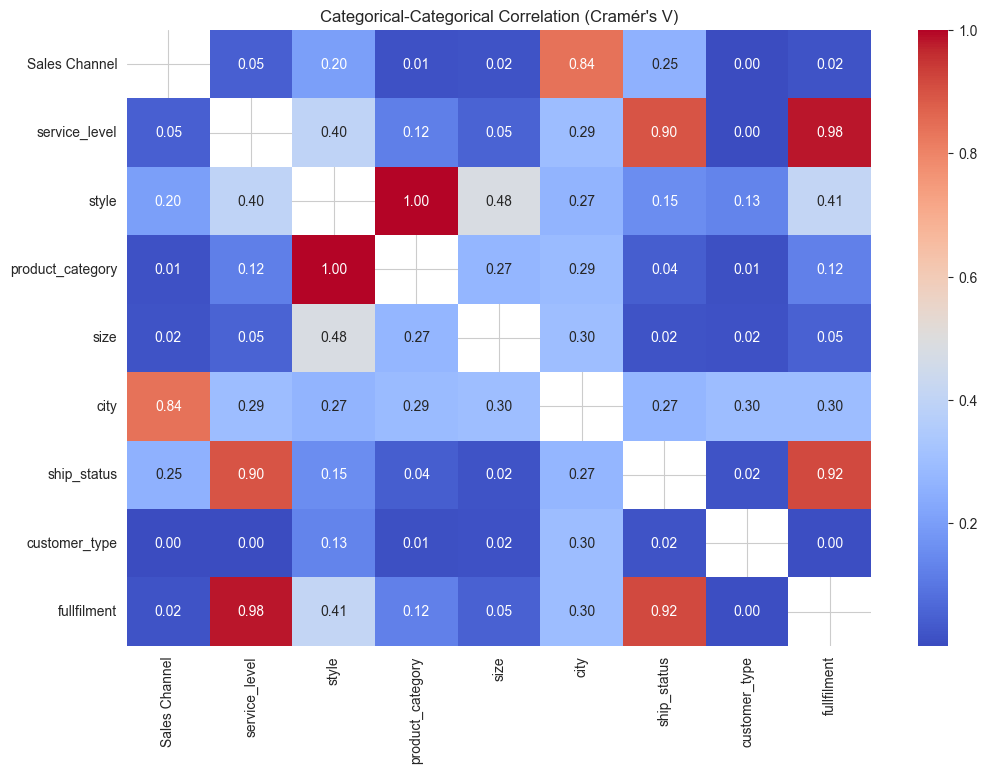

In [24]:
df = Amazon_df.copy()

df.columns = df.columns.str.strip()

categorical_cols = ['Sales Channel', 'service_level', 'style', 'product_category', 'size', 'city', 'ship_status', 'customer_type', 'fullfilment']
numerical_cols = ['order_quantity', 'order_amount_(Rs)']

df = df.dropna(subset=categorical_cols + numerical_cols)

numerical_corr = df[numerical_cols].corr()

le = LabelEncoder()
df_encoded = df.copy()

for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col].astype(str))

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

cat_cat_corr = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            cat_cat_corr.loc[col1, col2] = cramers_v(df[col1], df[col2])

cat_cat_corr = cat_cat_corr.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Numerical-Numerical Correlation")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(cat_cat_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Categorical-Categorical Correlation (Cramér's V)")
plt.show()


In [25]:
Sale_report_df_clean = Sale_report_df.dropna(subset=['SKU Code'])
Sale_report_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9188 entries, 0 to 9234
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9188 non-null   int64  
 1   SKU Code    9188 non-null   object 
 2   Design No.  9188 non-null   object 
 3   Stock       9188 non-null   float64
 4   Category    9188 non-null   object 
 5   Size        9188 non-null   object 
 6   Color       9188 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 574.2+ KB


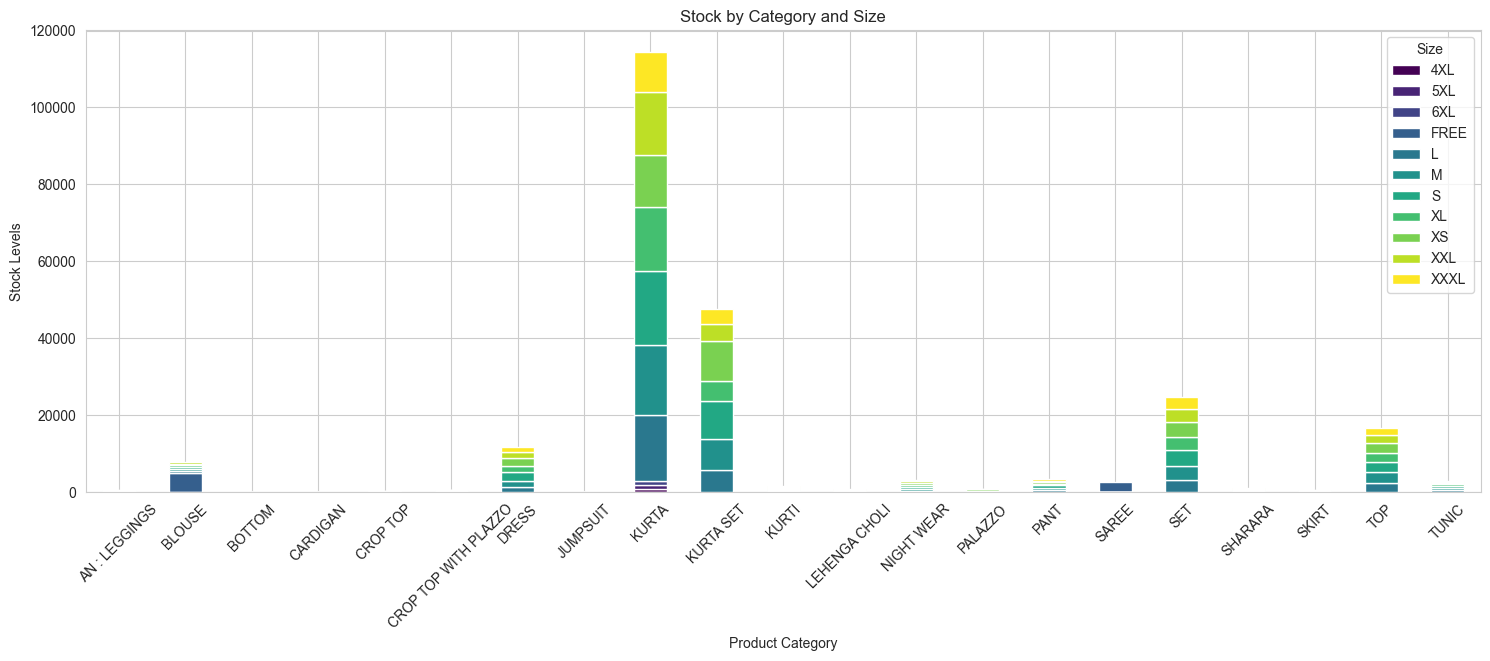

In [26]:
stock_by_size_and_category = Sale_report_df_clean.groupby(['Category', 'Size'])['Stock'].sum().unstack().fillna(0)
stock_by_size_and_category.plot(kind='bar', stacked=True, figsize=(18, 6), colormap='viridis')
plt.title('Stock by Category and Size')
plt.xlabel('Product Category')
plt.ylabel('Stock Levels')
plt.xticks(rotation=45)
plt.legend(title='Size')
plt.grid(True)
plt.show()
#plt.savefig('stock by category and size.png', dpi=300)